In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Cityscapes
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split


2023-12-03 17:08:04.390133: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 17:08:04.440142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 17:08:04.440195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 17:08:04.441466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 17:08:04.450312: I tensorflow/core/platform/cpu_feature_guar

In [2]:
device = torch.device("cuda")

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 512
LR = 0.0005
MOMEMNTUM = 0.9
OPTIMIZER = "Adam"
N_CLASSES = 8
NUM_EPOCHS = 20

In [3]:
class Unet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [4]:
class ToTensorImage(object):
    def __call__(self, pic):
        image = TF.resize(pic, size=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=Image.BILINEAR)
        image = TF.to_tensor(image)
        return image

# Трансформации для изображений и масок
transform = transforms.Compose([
    ToTensorImage(),
])

color_mapping = {
    (0, 0, 0): 0,
    (128, 64, 128): 1,
    (70, 70, 70): 2,
    (153, 153, 153): 3,
    (107, 142, 35): 4,
    (70, 130, 180): 5,
    (220, 20, 60): 6,
    (0, 0, 142): 7,
}

class ToTensorTarget(object):
    def __call__(self, pic):
        target = TF.resize(pic, size=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=Image.NEAREST)
        target = torch.from_numpy(np.array(target, dtype=np.int64)).long()
        
        # Преобразование RGB в монотонное 
        height, width, _ = target.shape
        rgb_values = target[:, :, :3].numpy()
        rgb_tuples = [tuple(rgb) for rgb in rgb_values.reshape(-1, 3)]
        mapped_values = np.array([color_mapping.get(rgb, N_CLASSES) for rgb, x in zip(rgb_tuples, target[:, :, 3].reshape(-1))], dtype=np.int64)
        mapped_tensor = torch.from_numpy(mapped_values).reshape(height, width)

        return mapped_tensor

target_transform = transforms.Compose([
    ToTensorTarget(),
])

data_dir = "/home/vorkov/Workspace/Python/Segmentation/datasets"
batch_size = 10
train_dataset = Cityscapes(root=data_dir, split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
val_dataset = Cityscapes(root=data_dir, split='val', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
test_dataset = Cityscapes(root=data_dir, split='test', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Text(0.5, 1.0, 'Label Class')

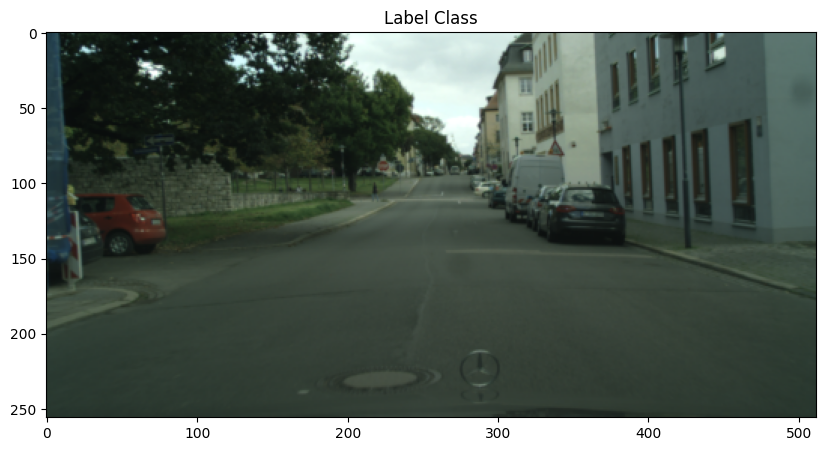

In [5]:
_, axes = plt.subplots(1, 1, figsize=(3*5, 1*5))
axes.imshow(test_loader.dataset[0][0].cpu().numpy().transpose((1, 2, 0)))
axes.set_title("Label Class")

Text(0.5, 1.0, 'Label Class')

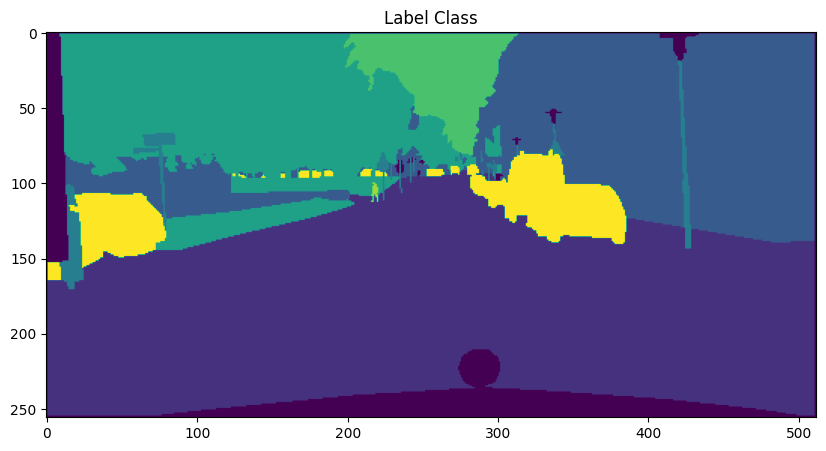

In [6]:
_, axes = plt.subplots(1, 1, figsize=(3*5, 1*5))
axes.imshow(test_loader.dataset[0][1].cpu().numpy())
axes.set_title("Label Class")

In [7]:

test_loader.dataset[0][1].cpu().numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 2, 0],
       [0, 0, 0, ..., 2, 2, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
writer = SummaryWriter(filename_suffix=f"Size({IMAGE_HEIGHT}_{IMAGE_WIDTH})_Epochs{NUM_EPOCHS}_Optimizer{OPTIMIZER}_LR{LR}_Momentum{MOMEMNTUM}")
model = Unet(N_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
dice = torchmetrics.Dice().to(device)

if OPTIMIZER == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMEMNTUM)
elif OPTIMIZER == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    print(f"epoch: {epoch}")
    
    model.train()
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.squeeze(1).to(device)
        y = y.squeeze(1).to(device)
        
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
        
        writer.add_scalar('Metrics/step_losses', loss.item(), epoch*len(train_loader)+i)


    test_loss = 0.0
    total_dice_score = 0.0
    model.eval()
    with torch.no_grad():
        for i, (x_test, y_test) in enumerate(val_loader):
            x_test = x_test.squeeze(1).to(device)
            y_test = y_test.squeeze(1).to(device)
    
            y_pred_test = model(x_test)
            loss = loss_fn(y_pred_test, y_test)
    
            y_pred_test = y_pred_test.argmax(dim=1)
            dice_score = dice(y_pred_test, y_test)
            total_dice_score += dice_score
    
    average_dice_score = total_dice_score / len(val_loader)
    writer.add_scalar('Metrics/dice_score_val', average_dice_score, epoch)
        
print('Training finished')

epoch: 0


100%|██████████| 262/262 [03:49<00:00,  1.14it/s]


epoch: 1


100%|██████████| 262/262 [04:03<00:00,  1.08it/s]


epoch: 2


100%|██████████| 262/262 [03:14<00:00,  1.35it/s]


epoch: 3


 44%|████▎     | 114/262 [01:18<01:42,  1.45it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/vorkov/Workspace/Python/Segmentation/venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/vorkov/Workspace/Python/Segmentation/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/vorkov/Workspace/Python/Segmentation/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/vorkov/Workspace/Python/Segmentation/venv/lib/python3.10/site-packages/torchvision/datasets/cityscapes.py", line 190, in __getitem__
    target = Image.open(self.targets[index][i])
  File "/home/vorkov/Workspace/Python/Segmentation/venv/lib/python3.10/site-packages/PIL/Image.py", line 3243, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/vorkov/Workspace/Python/Segmentation/datasets/gtFine/train/krefeld/krefeld_000000_010653_gtFine_labelIds.png'


In [ ]:
model_name = f"Size({IMAGE_HEIGHT}_{IMAGE_WIDTH})_Epochs{NUM_EPOCHS}_Optimizer{OPTIMIZER}_LR{LR}_Momentum{MOMEMNTUM}.pth"
torch.save(model.state_dict(), "models/" + model_name)

In [ ]:
# model_name = "/home/vorkov/Workspace/Python/Segmentation/Size(256_512)_OptimizerSGD_LR0.01_Momentum0.9.pth"
print(model_name)
model_ = Unet(N_CLASSES).to(device)
model_.load_state_dict(torch.load(model_name))

In [ ]:
X, Y = next(iter(test_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
Y_pred = torch.argmax(Y_pred, dim=1)

_, axes = plt.subplots(batch_size, 3, figsize=(3*5, batch_size*5))

for i in range(batch_size):
    
    img_original = X[i].cpu().numpy().transpose((1, 2, 0))
    img_mask = Y[i].cpu().numpy()
    img_mask_pred = Y_pred[i].cpu().numpy()

    axes[i, 0].imshow(img_original)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(img_mask)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(img_mask_pred)
    axes[i, 2].set_title("Label Class - Predicted")

In [ ]:
import torch

model.eval()  # Set the model to evaluation mode
test_loss = 0.0
total_dice_score = 0.0
dice = torchmetrics.Dice().to(device)

with torch.no_grad():  # No need to calculate gradients during testing
    for i, (inputs, targets) in tqdm(enumerate(test_loader), total=len(test_loader), desc='Testing'):
        inputs = inputs.squeeze(1).to(device)
        targets = targets.squeeze(1).to(device)

        # Make predictions
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, targets)

        # Calculate Dice score
        pred_masks = outputs
        dice_score = dice(pred_masks, targets)
        total_dice_score += dice_score

        # Gather data and report
        test_loss += loss.item()

# Calculate and print average test loss and Dice score
average_test_loss = test_loss / len(test_loader)
average_dice_score = total_dice_score / len(test_loader)

with open('results.txt', 'a') as file:
    file.write(f'Size ({IMAGE_HEIGHT}, {IMAGE_WIDTH}); Epochs{NUM_EPOCHS}; Optimizer: {OPTIMIZER}; LR: {LR}; Momentum: {MOMEMNTUM}; Loss: {average_test_loss:.3f}; Dice Score: {average_dice_score:.3f}\n')
print(f'Size ({IMAGE_HEIGHT}, {IMAGE_WIDTH}); Epochs{NUM_EPOCHS}; Optimizer: {OPTIMIZER}; LR: {LR}; Momentum: {MOMEMNTUM}; Loss: {average_test_loss:.3f}; Dice Score: {average_dice_score:.3f}')